In [1]:
# 下载字体
!wget https://github.com/wkwbk/ipynb/raw/main/%E6%95%B0%E6%8D%AE%E9%87%87%E9%9B%86/SimHei.ttf

--2025-04-24 12:21:59--  https://github.com/wkwbk/ipynb/raw/main/%E6%95%B0%E6%8D%AE%E9%87%87%E9%9B%86/SimHei.ttf
Resolving github.com (github.com)... 140.82.116.3
Connecting to github.com (github.com)|140.82.116.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/wkwbk/ipynb/main/%E6%95%B0%E6%8D%AE%E9%87%87%E9%9B%86/SimHei.ttf [following]
--2025-04-24 12:22:00--  https://raw.githubusercontent.com/wkwbk/ipynb/main/%E6%95%B0%E6%8D%AE%E9%87%87%E9%9B%86/SimHei.ttf
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9751960 (9.3M) [application/octet-stream]
Saving to: ‘SimHei.ttf’

SimHei.ttf          100%[===================>]   9.30M  --.-KB/s    in 0.09s   

2025-04-24 12:22:00 (103 MB/s) - ‘SimHei.ttf

In [2]:
# 添加字体文件
import matplotlib.font_manager as fm

fm.fontManager.addfont('./SimHei.ttf')

In [3]:
# 导入必要的库
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from typing import Dict, List, Tuple
import typing_extensions
# 设置 matplotlib 支持中文字体
plt.rcParams['font.sans-serif'] = ['SimHei']  # 设置字体为黑体
plt.rcParams['axes.unicode_minus'] = False    # 正确显示负号
# 设置随机种子以确保结果可复现
np.random.seed(42)

In [4]:
# 测试数据
sentences = [
     "自监督学习减少对标注数据的依赖",
    "模型微调适应特定领域任务",
    "评估指标衡量算法性能优劣",
    "过拟合问题影响模型的泛化能力"]
# 配置模型训练所需的超参数
CONFIG = {
    "window_size": 2,  # 上下文窗口大小
    "embedding_dim": 16,  # 词向量的维度
    "initial_lr": 0.1,  # 初始学习率
    "min_epochs": 200,  # 最小训练轮数
    "patience": 100,  # 早停机制的耐心值，即允许损失不下降的最大轮数
    "min_delta": 1e-4,  # 早停机制中损失改善的最小阈值
    "l2_lambda": 0.001,  # L2正则化系数
    "momentum": 0.9,  # 动量系数
    "max_grad_norm": 5.0,  # 梯度裁剪的最大范数
    "batch_size": 32  # 批量大小
}

In [5]:
def build_vocab(sentences: List[str]) -> Tuple[List[str], Dict, Dict]:
    # 将所有句子中的词拆分成单个字符，并存储在一个列表中
    words = [word for sent in sentences for word in list(sent)]
    vocab = list(set(words))
# 返回词汇表、词到索引的映射和索引到词的映射
    return vocab, {word: idx for idx, word in enumerate(vocab)}, \
    {idx: word for idx, word in enumerate(vocab)}

In [6]:
def create_cbow_data(sentences: List[str], window_size: int) -> List[Tuple]:
    data = []
    for sent in sentences:
        # 将句子拆分成单个字符
        words = list(sent)
        # 遍历句子中的每个词，排除窗口范围内无法构成完整上下文的词
        for i in range(window_size, len(words) - window_size):
            # 提取当前词的上下文，即窗口内除当前词以外的所有词
            context = [words[i + j] for j in range(-window_size, window_size + 1) if j != 0]
            # 当前词作为目标词
            target = words[i]
            # 将上下文和目标词作为一个元组添加到数据列表中
            data.append((context, target))
    return data

In [10]:
class CBOW_Model:
    def __init__(self, vocab_size: int, config: dict):
        # 词汇表大小
        self.vocab_size = vocab_size
        # 超参数配置
        self.config = config
        # 初始化嵌入层权重，使用 Xavier 初始化方法
        self.embed_weights = np.random.randn(vocab_size, config["embedding_dim"]) * np.sqrt(2. / (vocab_size + config["embedding_dim"]))
        # 初始化上下文层权重，使用 Xavier 初始化方法
        self.context_weights = np.random.randn(config["embedding_dim"], vocab_size) * np.sqrt(2. / (config["embedding_dim"] + vocab_size))
        # 初始化嵌入层动量
        self.embed_momentum = np.zeros_like(self.embed_weights)
        # 初始化上下文层动量
        self.context_momentum = np.zeros_like(self.context_weights)
 # 实现softmax函数，用于将输入转换为概率分布
    def softmax(self, x: np.ndarray) -> np.ndarray:
        # 为了避免数值溢出，先减去最大值
        x = x - np.max(x)
        e_x = np.exp(x)
        return e_x / np.sum(e_x)
     # 前向传播和反向传播函数，计算损失和梯度
    def forward_backward(self, context_indices: List[int], target_idx: int) -> Tuple[float, np.ndarray, np.ndarray, np.ndarray]:
        x = np.zeros(self.vocab_size)
        # 将上下文词的索引对应的向量元素累加，并除以上下文词的数量
        for idx in context_indices:
            x[idx] += 1 / len(context_indices)
        # 计算隐藏层向量
        h = np.dot(x, self.embed_weights)
        # 计算logits
        logits = np.dot(h, self.context_weights)
        # 计算概率分布
        probs = self.softmax(logits)
        # 计算损失，包括交叉熵损失和L2正则化项
        loss = -np.log(probs[target_idx] + 1e-8) + 0.5 * self.config["l2_lambda"] * (
                np.sum(self.embed_weights ** 2) + np.sum(self.context_weights ** 2))
        # 计算logits的梯度
        d_logits = probs.copy()
        d_logits[target_idx] -= 1
        # 计算上下文层权重的梯度
        grad_context = np.outer(h, d_logits) + self.config["l2_lambda"] * self.context_weights
        # 计算隐藏层的梯度
        dh = np.dot(self.context_weights, d_logits)
        # 计算嵌入层权重的梯度
        grad_embed = np.outer(x, dh) + self.config["l2_lambda"] * self.embed_weights
        # 返回损失、嵌入层梯度、上下文层梯度和概率分布
        return loss, grad_embed, grad_context, probs
    # 更新模型参数，使用动量优化器
    def update_parameters(self, gradients: Tuple[np.ndarray, np.ndarray], lr: float):
        # 解包梯度
        grad_embed, grad_context = gradients
        # 计算梯度的总范数
        total_norm = np.sqrt(np.sum(grad_embed ** 2) + np.sum(grad_context ** 2))
        # 如果总范数超过最大范数，则进行梯度裁剪
        if total_norm > self.config["max_grad_norm"]:
            scale = self.config["max_grad_norm"] / total_norm
            grad_embed *= scale
            grad_context *= scale
  # 更新嵌入层动量
        self.embed_momentum = self.config["momentum"] * self.embed_momentum + (1 - self.config["momentum"]) * grad_embed
        # 更新上下文层动量
        self.context_momentum = self.config["momentum"] * self.context_momentum + (1 - self.config["momentum"]) * grad_context
        # 更新嵌入层权重
        self.embed_weights -= lr * self.embed_momentum
        # 更新上下文层权重
        self.context_weights -= lr * self.context_momentum

In [11]:
# 训练CBOW模型
def train_model(sentences: List[str], config: dict) -> Tuple[CBOW_Model, dict, Dict, Dict]:
    # 构建词汇表和词索引映射
    vocab, word_to_idx, idx_to_word = build_vocab(sentences)
    # 创建训练数据
    training_data = create_cbow_data(sentences, config["window_size"])
    print(f"生成训练样本数: {len(training_data)}")
    print(f"词汇表: {vocab}")
    # 初始化CBOW模型
    model = CBOW_Model(len(vocab), config)
    # 记录训练历史
    history = defaultdict(list)
    # 初始化最佳损失为正无穷
    best_loss = float('inf')
    # 初始化早停计数器
    no_improve = 0
    print("\n开始训练...")
    for epoch in range(10000):
        # 学习率衰减
        lr = config["initial_lr"] * (0.95 ** (epoch // 50))
        # 初始化总损失
        total_loss = 0
        # 初始化正确预测的样本数
        correct = 0
 # 打乱训练数据
        np.random.shuffle(training_data)
        for i in range(0, len(training_data), config["batch_size"]):
            # 取一个批次的数据
            batch = training_data[i:i + config["batch_size"]]
            if len(batch) == 0:
                continue
            # 初始化批次梯度
            batch_grad_e = np.zeros_like(model.embed_weights)
            batch_grad_c = np.zeros_like(model.context_weights)
            for context, target in batch:
                # 将上下文词转换为索引
                context_idx = [word_to_idx[w] for w in context]
                # 将目标词转换为索引
                target_idx = word_to_idx[target]
                # 前向传播和反向传播，计算损失和梯度
                loss, grad_e, grad_c, probs = model.forward_backward(context_idx, target_idx)
                # 获取预测的索引
                predicted_idx = np.argmax(probs)
                if predicted_idx == target_idx:
                    correct += 1
                # 累加梯度
                batch_grad_e += grad_e
                batch_grad_c += grad_c
                # 累加损失
                total_loss += loss
            # 计算批次平均梯度
            batch_grad_e /= len(batch)
            batch_grad_c /= len(batch)
            # 更新模型参数
            model.update_parameters((batch_grad_e, batch_grad_c), lr)
        # 计算平均损失
        avg_loss = total_loss / len(training_data)
        # 计算准确率
        accuracy = correct / len(training_data)
        # 记录损失、准确率和学习率
        history['loss'].append(avg_loss)
        history['acc'].append(accuracy)
        history['lr'].append(lr)
        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch + 1:4d} | Loss: {avg_loss:.4f} | Acc: {accuracy:.2%} | LR: {lr:.5f}")
        if epoch >= config["min_epochs"]:
            if avg_loss < best_loss - config["min_delta"]:
                # 如果损失有改善，更新最佳损失并重置早停计数器
                best_loss = avg_loss
                no_improve = 0
            else:
                # 如果损失没有改善，早停计数器加1
                no_improve += 1
            if no_improve >= config["patience"]:
                print(f"\n早停触发：连续 {config['patience']} 轮损失未改善")
                break
    print(f"训练结束，最优损失: {best_loss:.4f}")
    return model, history, word_to_idx, idx_to_word

In [12]:
# 可视化训练结果
def visualize_results(model: CBOW_Model, history: dict, idx_to_word: Dict[int, str]):
    plt.figure(figsize=(18, 5))
    # 绘制训练损失曲线，使用对数尺度
    plt.subplot(1, 3, 1)
    plt.semilogy(history['loss'])
    plt.title("训练损失（对数尺度）")
    plt.xlabel("Epoch")
    # 绘制训练准确率曲线
    plt.subplot(1, 3, 2)
    plt.plot(history['acc'])
    plt.title("训练准确率")
    plt.xlabel("Epoch")
    # 绘制学习率曲线
    plt.subplot(1, 3, 3)
    plt.plot(history['lr'])
    plt.title("学习率调度")
    plt.xlabel("Epoch")
    plt.tight_layout()
    # 计算词向量的相似度矩阵
    vectors = model.embed_weights
    sim_matrix = vectors @ vectors.T
    norms = np.linalg.norm(vectors, axis=1, keepdims=True)
    sim_matrix /= (norms @ norms.T)
    # 绘制相似度矩阵热力图
    plt.figure(figsize=(10, 5))
    plt.imshow(sim_matrix, cmap='coolwarm', vmin=-1, vmax=1)
    plt.colorbar()
    plt.xticks(range(len(idx_to_word)), [idx_to_word[i] for i in range(len(idx_to_word))], rotation=90)
    plt.yticks(range(len(idx_to_word)), [idx_to_word[i] for i in range(len(idx_to_word))])
    plt.title("词相似度矩阵")
    plt.show()

生成训练样本数: 37
词汇表: ['应', '监', '泛', '化', '依', '标', '领', '微', '少', '注', '评', '影', '力', '型', '性', '数', '域', '过', '合', '自', '赖', '据', '适', '估', '劣', '的', '模', '习', '督', '对', '能', '衡', '特', '任', '题', '算', '调', '优', '学', '问', '减', '指', '量', '响', '定', '法', '拟', '务']

开始训练...
Epoch   10 | Loss: 3.8911 | Acc: 2.70% | LR: 0.10000
Epoch   20 | Loss: 3.8799 | Acc: 2.70% | LR: 0.10000
Epoch   30 | Loss: 3.8681 | Acc: 2.70% | LR: 0.10000
Epoch   40 | Loss: 3.8563 | Acc: 5.41% | LR: 0.10000
Epoch   50 | Loss: 3.8445 | Acc: 5.41% | LR: 0.10000
Epoch   60 | Loss: 3.8332 | Acc: 8.11% | LR: 0.09500
Epoch   70 | Loss: 3.8219 | Acc: 10.81% | LR: 0.09500
Epoch   80 | Loss: 3.8104 | Acc: 21.62% | LR: 0.09500
Epoch   90 | Loss: 3.7987 | Acc: 21.62% | LR: 0.09500
Epoch  100 | Loss: 3.7867 | Acc: 27.03% | LR: 0.09500
Epoch  110 | Loss: 3.7751 | Acc: 29.73% | LR: 0.09025
Epoch  120 | Loss: 3.7633 | Acc: 29.73% | LR: 0.09025
Epoch  130 | Loss: 3.7509 | Acc: 43.24% | LR: 0.09025
Epoch  140 | Loss: 3.7384 | Acc: 45.9

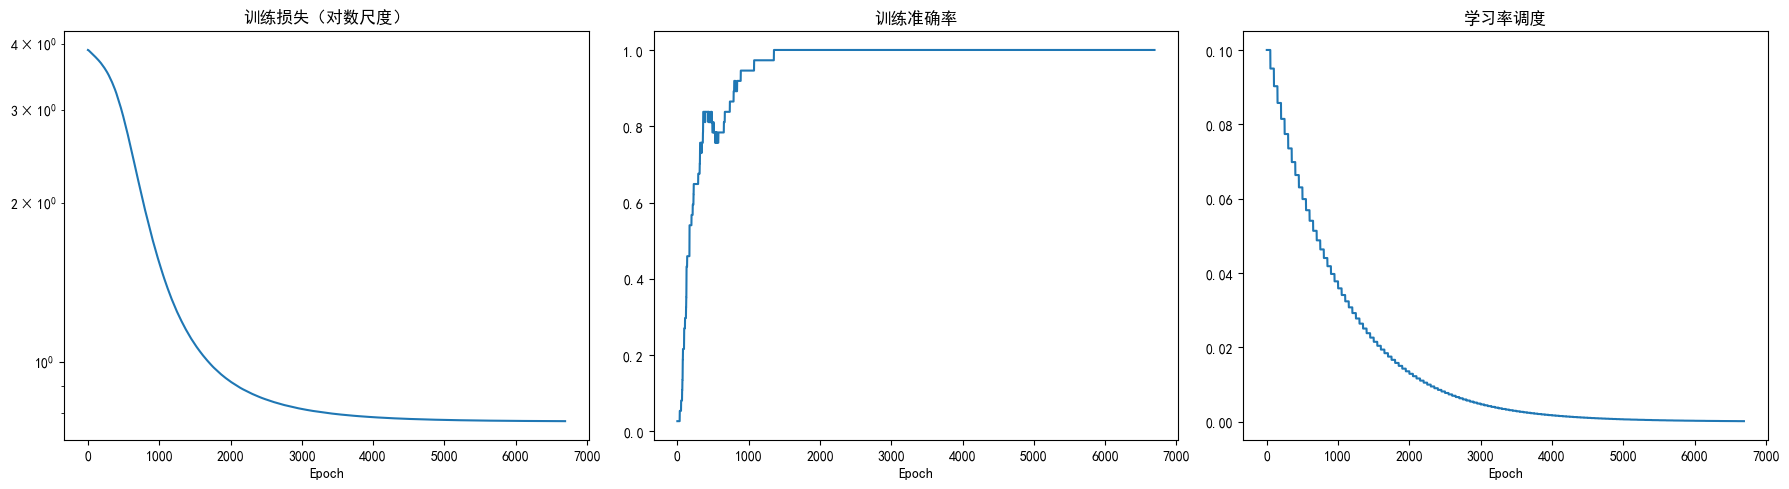

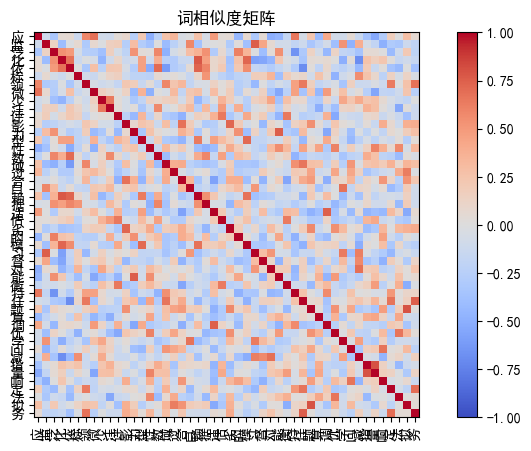


示例词向量：
应: [ 1.1608 -0.0046  0.0674  1.1976  0.1473 -0.2716  1.5173  0.5593 -0.5272
  0.5647  0.0629 -0.857   0.4314 -1.3561 -1.41   -0.3262]
监: [-0.4488  0.5082  0.0939 -0.9085  0.7172 -0.6089  0.4242 -0.3439 -0.1021
  0.1777 -0.5967  0.2733 -0.008  -0.0351 -0.449   1.4819]
泛: [-0.7765 -0.4913  0.6541 -0.5073 -0.4522 -0.534  -0.3177 -0.2935  1.5377
  0.747  -0.4651  0.2696 -0.5106 -0.3807  0.1548 -0.0922]
化: [-0.239  -0.0351  0.2869  0.2525 -0.3917  0.3291  0.1345  0.2621  0.7403
  0.3973 -0.5154  0.5873 -0.551  -0.3929 -0.0921 -1.1199]
依: [-0.4964  0.2433  0.6246  0.1461 -0.0483 -0.3847  0.056   0.2068  0.4998
  0.6516 -0.9769  0.2847  0.1499  0.2738 -0.4613 -0.9983]
标: [-0.9015  1.0308 -0.1186 -0.7387 -1.9844 -0.0475 -0.7748  0.2456 -1.9107
  0.751  -0.5551 -0.6096  0.1434 -0.4124  0.4348  0.2894]
领: [ 0.8567 -0.6339  0.4412  1.1584 -0.7267  0.7272  0.1387  0.2445 -0.3286
 -0.0374  0.7529  0.1395  0.2129 -0.8924 -0.8744  0.6047]
微: [ 0.2213  0.8294 -0.1243  0.296   0.4051 -0.768   1

In [13]:
if __name__ == "__main__":
    # 训练模型
    trained_model, training_history, word_to_idx, idx_to_word = train_model(sentences, CONFIG)
    # 可视化训练结果
    visualize_results(trained_model, training_history, idx_to_word)
    print("\n示例词向量：")
    for idx in range(len(idx_to_word)):
        # 获取词
        word = idx_to_word[idx]
        # 打印词和对应的词向量
        print(f"{word}: {trained_model.embed_weights[idx].round(4)}")
print("主程序")